In [10]:
## anaconda3 (Python 3.12.0) Kernel
import numpy as np

# pair trade packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

# Load Pairs Data


In [11]:
def custom_date_parser(date_str):
    return datetime.strptime(date_str, '%d/%m/%Y')

# Load the dictionary from the pickle file
with open('pairsOutcome.pkl', 'rb') as file:
    pairsOutcome = pickle.load(file)

print("Dictionary loaded from pairsOutcome.pkl")


# Load stock data and get return 
tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)
tpxData = tpxData.dropna(axis='columns')
return_df = (tpxData / tpxData.shift(1)) - 1

Dictionary loaded from pairsOutcome.pkl


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_9267/3199335484.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  tpxData = pd.read_csv('TPX_prices.csv', index_col=0, parse_dates=True, date_parser=custom_date_parser)


# Get Pair Trade Portfolio
`pairsOutcome` already have TOPIX stocks with highest liquidity and are tested for stationarity over a 1 year window

Choose top 10 known pair trades by returns in the total dataset

In [12]:
import csv

with open("output_clustering.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    working_pairs = [tuple(row) for row in reader]


top_keys = [f"{pair[0]} {pair[1]}" for pair in working_pairs]

print("10 clustered pair trades:")
for i, key in enumerate(top_keys, 1):
    print(f"{i}. Key: {key}, Value: {pairsOutcome[key].cumpnl.iloc[-2]:.2f}")

10 clustered pair trades:
1. Key: 6503 JP Equity 7269 JP Equity, Value: 1.33
2. Key: 6326 JP Equity 6954 JP Equity, Value: 1.19
3. Key: 8053 JP Equity 8058 JP Equity, Value: 0.52
4. Key: 4901 JP Equity 9613 JP Equity, Value: 1.10
5. Key: 6988 JP Equity 7267 JP Equity, Value: 0.65
6. Key: 4901 JP Equity 6702 JP Equity, Value: -0.34
7. Key: 4684 JP Equity 7832 JP Equity, Value: 0.89
8. Key: 7267 JP Equity 8306 JP Equity, Value: 1.16
9. Key: 7267 JP Equity 8801 JP Equity, Value: 0.64
10. Key: 4519 JP Equity 7532 JP Equity, Value: 1.14


In [13]:
valid = pd.read_csv('validPairs5.csv', 
                    index_col=0, 
                    parse_dates=True, 
                    date_parser=custom_date_parser)
## get list of pair stocks
validPairsList = [
    [item.strip() + ' Equity' for item in pair.split('Equity') if item.strip()]
    for pair in top_keys
]
rollingWindow = 262
cutLossSd = 2
for pair in validPairsList:
    df = pd.DataFrame()

    #Calculate Standard Deviations
    df['spread'] = valid[f'spread_{pair[0]}_{pair[1]}']
    df['mid'] =  df['spread'].rolling(rollingWindow).mean()
    df['1sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std()
    df['1sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std()
    df['2sd high'] = df['spread'].rolling(rollingWindow).mean() + df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['2sd low'] = df['spread'].rolling(rollingWindow).mean() - df['spread'].rolling(rollingWindow).std() * cutLossSd
    df['position'] = 0

    df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high']), 'position'] = -1
    df.loc[(df['spread']< df['1sd low']) & (df['spread'] > df['2sd low']), 'position'] = 1

    #Calculate PnL
    df[f'{pair[0]} position'] = df['position']
    df[f'{pair[1]} position'] = df['position'] * -1
    df['dailypnl'] = df[f'{pair[1]} position']*return_df[f'{pair[1]}'].shift(-1) + df[f'{pair[0]} position']*return_df[f'{pair[0]}'].shift(-1)
    df['cumpnl'] = df['dailypnl'].cumsum()

    pairsOutcome[f'{pair[0]} {pair[1]}'] = df

/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_9267/312682044.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  valid = pd.read_csv('validPairs5.csv',


## Make indicators and spread stationary around 0
Deduct the mean from all values to translate to 0 axis

In [14]:
workingPairOutcome = {}

for pair in top_keys:
    dummy_df = pairsOutcome[top_keys[0]].iloc[::,:6]
    dummy_df = dummy_df.subtract(dummy_df['mid'], axis=0).drop(columns=['mid']) # centre spread and SD
    dummy_df = dummy_df.div(dummy_df['2sd high']-dummy_df['1sd high'],axis=0)   # express SD as integers, give spread as propotionate
    dummy_df['2sd_high_boolean'] = (dummy_df['spread']>dummy_df['2sd high']).astype(int)
    dummy_df['1sd_high_boolean'] = (dummy_df['spread']>dummy_df['1sd high']).astype(int)
    dummy_df['0sd_high_boolean'] = (dummy_df['spread']>0).astype(int)
    dummy_df['0sd_low_boolean']  = (dummy_df['spread']<0).astype(int)
    dummy_df['1sd_low_boolean']  = (dummy_df['spread']<dummy_df['1sd low'] ).astype(int)
    dummy_df['2sd_low_boolean']  = (dummy_df['spread']<dummy_df['2sd low'] ).astype(int)
    dummy_df = dummy_df.drop(columns=['spread','1sd high', '1sd low', '2sd high', '2sd low'])
    workingPairOutcome[pair] = dummy_df.to_numpy()
workingPairOutcome[top_keys[5]][-5:]     # spread is not a proportion and direction of SD

array([[0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0]])

# Machine Learning Challenge

## Background
Initial evaluation of the baseline portfolio shows that draw downs are small. Originally team had the idea of using Machine Learning to optimise for sizing of these pair trades. However since there was no significant drawdowns the returns are linearly increasing with investment sizing i.e. greater nominal investment in the the pair trade the proportionate increase in returns without realising significant drawdown risk.

Instead of optimising for sizing, we can explore Machine Learning in terms of strategy on this stationary dataset. Whereas our prescribed strategy is to enter at +/- 1 std dev, exit at 0 with +/- 2 std dev stop loss. These are only suggestions and arbitrary levels.

With Machine Learning, we can discover if it will uncover the mean reverting nature and recommend another threshhold. We use Q Learner to understand state space with the same spread, mid, std dev parameters as the baseline.

### Q Value table

In [15]:
workingPairOutcome[top_keys[0]][261]

array([0, 1, 1, 0, 0, 0])

In [16]:
df = pairsOutcome[top_keys[0]]
df.tail()

,spread,mid,1sd high,1sd low,2sd high,2sd low,position,6503 JP Equity position,7269 JP Equity position,dailypnl,cumpnl
Date,,,,,,,,,,,
2024-05-27,711.312149,312.114302,519.582968,104.645636,727.051634,-102.823030,-1,-1,1,-0.008760,1.308067
2024-05-28,729.471175,313.747398,522.810854,104.683941,731.874311,-104.379515,-1,-1,1,0.035074,1.343141
2024-05-29,616.692335,314.853872,524.752129,104.955615,734.650386,-104.942642,-1,-1,1,0.027955,1.371096
2024-05-30,535.448255,315.684473,526.024663,105.344282,736.364854,-104.995908,-1,-1,1,-0.038680,1.332416
2024-05-31,644.564375,316.967564,528.286170,105.648958,739.604776,-105.669648,-1,-1,1,NaN,NaN


In [33]:
ls_pos = [-1,0,1]
pair = validPairsList[0]

#Calculate PnL
for pos in ls_pos:
    df[f'dailypnl_{pos}'] = pos*return_df[f'{pair[0]}'].shift(-1) + -pos*return_df[f'{pair[1]}'].shift(-1)

In [18]:
df

,spread,mid,1sd high,1sd low,2sd high,2sd low,position,6503 JP Equity position,7269 JP Equity position,dailypnl,cumpnl,dailypnl_-1,dailypnl_0,dailypnl_1
Date,,,,,,,,,,,,,,
2013-01-01,-303.939690,NaN,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000
2013-01-02,-303.939690,NaN,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.000000,0.000000,0.0,0.000000
2013-01-03,-303.939690,NaN,NaN,NaN,NaN,NaN,0,0,0,0.000000,0.000000,0.047930,0.0,-0.047930
2013-01-04,-316.816182,NaN,NaN,NaN,NaN,NaN,0,0,0,-0.000000,0.000000,-0.021472,-0.0,0.021472
2013-01-07,-307.755527,NaN,NaN,NaN,NaN,NaN,0,0,0,-0.000000,0.000000,-0.018079,-0.0,0.018079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,711.312149,312.114302,519.582968,104.645636,727.051634,-102.823030,-1,-1,1,-0.008760,1.308067,-0.008760,0.0,0.008760
2024-05-28,729.471175,313.747398,522.810854,104.683941,731.874311,-104.379515,-1,-1,1,0.035074,1.343141,0.035074,-0.0,-0.035074
2024-05-29,616.692335,314.853872,524.752129,104.955615,734.650386,-104.942642,-1,-1,1,0.027955,1.371096,0.027955,-0.0,-0.027955


In [34]:
ls_pos = [-1,0,1]
ls_res_111000 = []
ls_res_011000 = []
ls_res_001000 = []
ls_res_000100 = []
ls_res_000110 = []
ls_res_000111 = []
ls_df = []

for i, key in enumerate(top_keys):
    pair = validPairsList[i]
    df = pairsOutcome[key]
    for pos in ls_pos:
        df[f'dailypnl_{pos}'] = pos*return_df[f'{pair[0]}'].shift(-1) + -pos*return_df[f'{pair[1]}'].shift(-1)

    # above 2 high SD
    ls_res_111000.append(df.loc[(df['spread'] > df['2sd high'])][['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']].sum())
    # within 1 to 2 high SD
    ls_res_011000.append(df.loc[(df['spread'] > df['1sd high']) & (df['spread'] < df['2sd high'])][['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']].sum())
    # within 0 to 1 high SD
    ls_res_001000.append(df.loc[(df['spread'] > df['mid']) & (df['spread'] < df['1sd high'])][['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']].sum())
    # within 0 to 1 high SD
    ls_res_000100.append(df.loc[(df['spread'] < df['mid']) & (df['spread'] > df['1sd low'])][['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']].sum())
    # within 1 to 2 low SD
    ls_res_000110.append(df.loc[(df['spread'] > df['2sd low']) & (df['spread'] < df['1sd low'])][['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']].sum())
    # less than 2sd spread
    ls_res_000111.append(df.loc[(df['spread'] < df['2sd low'])][['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']].sum())

    ls_df.append(df)
    
ls_ls = [ls_res_111000,ls_res_011000, ls_res_001000,ls_res_000100,ls_res_000110,ls_res_000111]
ls_state_returns = []
for i, ls_ in enumerate(ls_ls):
    dummy_df = pd.concat(ls_, axis=1).T
    dummy_df['max return'] = dummy_df.idxmax(axis=1)
    ls_state_returns.append(dummy_df)


In [36]:
ls_df[0].columns

Index(['spread', 'mid', '1sd high', '1sd low', '2sd high', '2sd low',
       'position', '6503 JP Equity position', '7269 JP Equity position',
       'dailypnl', 'cumpnl', 'dailypnl_-1', 'dailypnl_0', 'dailypnl_1'],
      dtype='object')

In [40]:
ls_df = [df[['dailypnl_-1', 'dailypnl_0', 'dailypnl_1']] for df in ls_df]
dailypnl_df = pd.concat(ls_df).dropna()

In [51]:
dailypnl_df['dailypnl_-1'].describe()

count    29780.000000
mean         0.000008
std          0.018391
min         -0.238144
25%         -0.008742
50%          0.000000
75%          0.008738
max          0.199404
Name: dailypnl_-1, dtype: float64

In [52]:
dailypnl_df['dailypnl_1'].describe()

count    29780.000000
mean        -0.000008
std          0.018391
min         -0.199404
25%         -0.008738
50%          0.000000
75%          0.008742
max          0.238144
Name: dailypnl_1, dtype: float64

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 5.000e+00,
        1.300e+01, 1.000e+01, 1.600e+01, 1.100e+01, 2.000e+01, 1.900e+01,
        3.200e+01, 2.500e+01, 5.100e+01, 6.600e+01, 8.600e+01, 1.280e+02,
        1.800e+02, 2.640e+02, 3.780e+02, 6.600e+02, 8.760e+02, 1.291e+03,
        1.872e+03, 2.561e+03, 3.307e+03, 5.538e+03, 3.311e+03, 2.623e+03,
        1.997e+03, 1.366e+03, 9.400e+02, 6.610e+02, 4.100e+02, 2.990e+02,
        1.940e+02, 1.470e+02, 1.010e+02, 6.500e+01, 4.500e+01, 4.100e+01,
        3.300e+01, 2.200e+01, 1.600e+01, 1.200e+01, 8.000e+00, 7.000e+00,
        9.000e+00, 7.000e+00, 3.000e+00, 5.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+0

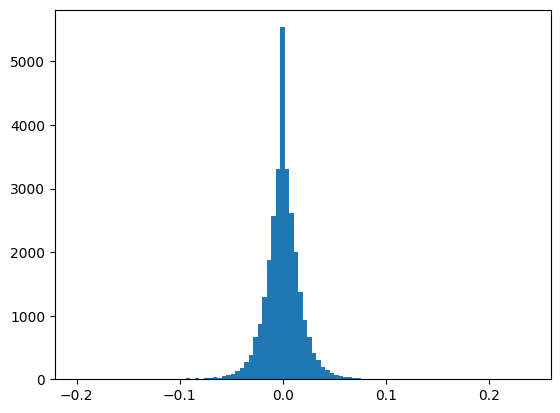

In [57]:
plt.hist(dailypnl_df['dailypnl_1'], bins=100)

there seems to be 0 mean for returns, maybe very small

In [27]:
states = ['111000','011000', '001000','000100','000110','000111']
for state, dummy_df in zip(states,ls_state_returns):
    print(f"Sum of returns for state {state}")
    print(dummy_df[dummy_df.columns[:-1]].sum(axis=0),"\n")

Sum of returns for state 111000
dailypnl_-1    3.114367
dailypnl_0     0.000000
dailypnl_1    -3.114367
dtype: float64 

Sum of returns for state 011000
dailypnl_-1    4.048432
dailypnl_0     0.000000
dailypnl_1    -4.048432
dtype: float64 

Sum of returns for state 001000
dailypnl_-1    2.009062
dailypnl_0     0.000000
dailypnl_1    -2.009062
dtype: float64 

Sum of returns for state 000100
dailypnl_-1   -2.440315
dailypnl_0     0.000000
dailypnl_1     2.440315
dtype: float64 

Sum of returns for state 000110
dailypnl_-1   -4.238304
dailypnl_0     0.000000
dailypnl_1     4.238304
dtype: float64 

Sum of returns for state 000111
dailypnl_-1   -2.398257
dailypnl_0     0.000000
dailypnl_1     2.398257
dtype: float64 



The above results show the reliability of mean reversion. In each state space we expect the returns to reward position that expect a return to mean.

However, although this trend is true in aggregate, there are some pairs where this rule does not hold. Below shows a sample of returns where the 2 of 17 pair trades have a greater return going long (instead of short) when the spread is over 2 SD.

In [30]:
dummy_df[dummy_df.columns[:-1]].mean()

dailypnl_-1   -0.239826
dailypnl_0     0.000000
dailypnl_1     0.239826
dtype: float64

In [21]:
dummy_df = ls_state_returns[0]
dummy_df

,dailypnl_-1,dailypnl_0,dailypnl_1,max return
0,0.530858,0.0,-0.530858,dailypnl_-1
1,0.486802,0.0,-0.486802,dailypnl_-1
2,0.161907,0.0,-0.161907,dailypnl_-1
3,0.206617,0.0,-0.206617,dailypnl_-1
4,0.177500,0.0,-0.177500,dailypnl_-1
5,0.238607,0.0,-0.238607,dailypnl_-1
6,-0.036494,0.0,0.036494,dailypnl_1
7,0.348275,0.0,-0.348275,dailypnl_-1
8,0.455133,0.0,-0.455133,dailypnl_-1
9,0.545163,0.0,-0.545163,dailypnl_-1


# checking state imbalances

In [22]:
from collections import Counter

In [23]:
array = np.concatenate([workingPairOutcome[key] for key in top_keys])
array_train = np.concatenate([workingPairOutcome[key][:2868] for key in top_keys])
array_test = np.concatenate([workingPairOutcome[key][2868:] for key in top_keys])

In [24]:
row_tuples = map(tuple, array)

# Count unique rows
row_counts = Counter(row_tuples)

print("="*5, "All Dataset State Distribution", "="*5)
for row, count in sorted(row_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"State: {row}, Count: {count}")

===== All Dataset State Distribution =====
State: (0, 0, 1, 0, 0, 0), Count: 7520
State: (0, 0, 0, 1, 0, 0), Count: 6750
State: (0, 1, 1, 0, 0, 0), Count: 5830
State: (0, 0, 0, 1, 1, 0), Count: 3140
State: (0, 0, 0, 0, 0, 0), Count: 2610
State: (0, 0, 0, 1, 1, 1), Count: 1980
State: (1, 1, 1, 0, 0, 0), Count: 1960


In [25]:
row_tuples = map(tuple, array_train)
row_counts = Counter(row_tuples)

print("="*5, "Train Dataset State Distribution", "="*5)
for row, count in sorted(row_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"State: {row}, Count: {count}")

===== Train Dataset State Distribution =====
State: (0, 0, 1, 0, 0, 0), Count: 7150
State: (0, 0, 0, 1, 0, 0), Count: 6720
State: (0, 1, 1, 0, 0, 0), Count: 5530
State: (0, 0, 0, 1, 1, 0), Count: 3130
State: (0, 0, 0, 0, 0, 0), Count: 2610
State: (0, 0, 0, 1, 1, 1), Count: 1980
State: (1, 1, 1, 0, 0, 0), Count: 1560


In [26]:
row_tuples = map(tuple, array_test)

# Count unique rows
row_counts = Counter(row_tuples)

print("="*5, "Test Dataset State Distribution", "="*5)
for row, count in sorted(row_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"State: {row}, Count: {count}")

===== Test Dataset State Distribution =====
State: (1, 1, 1, 0, 0, 0), Count: 400
State: (0, 0, 1, 0, 0, 0), Count: 370
State: (0, 1, 1, 0, 0, 0), Count: 300
State: (0, 0, 0, 1, 0, 0), Count: 30
State: (0, 0, 0, 1, 1, 0), Count: 10
